In [1]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

/Users/miguel/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


OS:  darwin
Python:  3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 18:11:28) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow:  1.5.0
Numpy:  1.14.1
Number of CPU processors:  8


### Data

In [2]:
DATA = os.path.join('data', 'MSFT_2012_2017.csv')
EPOCHS = 5
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
UNITS = 25

In [3]:
df = pd.read_csv(DATA)
df = df.drop(['Adj Close', 'Volume'], axis=1)
print(df.shape)
df.head()

(1509, 5)


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


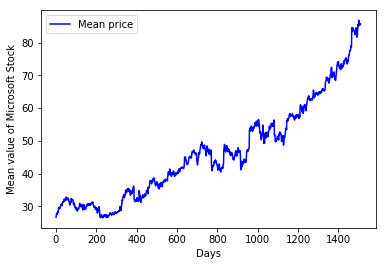

In [4]:
mean_price = df.mean(axis = 1)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

In [6]:
train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [7]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)

### LSTM

In [ ]:
def create_symbol(model_name='LSTM', units=10, activation='linear', time_ahead=1):
    if model_name == 'LSTM':
        cell = tf.contrib.rnn.LSTMCell(units)
    elif model_name == 'BiLSTM':
        
    elif model_name == 'GRU':
        cell = tf.contrib.rnn.GRUCell(units)
    else:
        raise ValueError("Wrong model name")
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model




def create_symbol(CUDNN=True, 
                  maxf=MAXFEATURES, edim=EMBEDSIZE, nhid=NUMHIDDEN, batchs=BATCHSIZE):
    word_vectors = tf.contrib.layers.embed_sequence(X, vocab_size=maxf, embed_dim=edim)
    word_list = tf.unstack(word_vectors, axis=1)
    
    if not CUDNN:
        cell = tf.contrib.rnn.GRUCell(nhid)
        outputs, states = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32)
    else:
        # Using cuDNN since vanilla RNN
        cudnn_cell = tf.contrib.cudnn_rnn.CudnnGRU(num_layers=1, 
                                                   num_units=nhid, 
                                                   input_size=edim)
        params_size_t = cudnn_cell.params_size()
        params = tf.Variable(tf.random_uniform([params_size_t], -0.1, 0.1), validate_shape=False)   
        input_h = tf.Variable(tf.zeros([1, batchs, nhid]))
        outputs, states = cudnn_cell(input_data=word_list,
                                     input_h=input_h,
                                     params=params)
        logits = tf.layers.dense(outputs[-1], 2, activation=None, name='output')